# Clean up for your vacation images

In [29]:
# Define global variables, are explained below

IMAGES = './images/' # path to the images
IMAGES_PREPROCESSED = './preprocessed/' # not used at the moment
IMAGES_PROCESSED = './processed/' # output destination
HASH_DIM = (8, 8)

In [30]:
import glob
import os
import shutil

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import spring_cleaning as sc # outsourced code

# How many correlations exist between images?

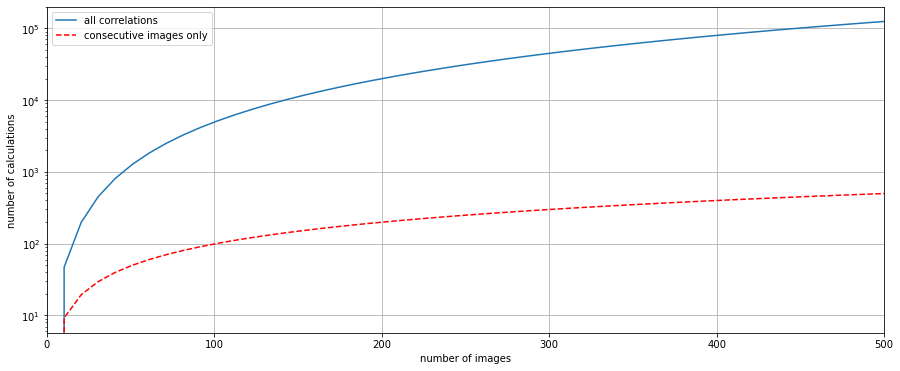

In [31]:
# function increases steeply, thus we make the assumption that only 
# consecutive images are related to each other

def corr(n):
    return n*(n-1)/2

n = np.linspace(0, 500)
plt.figure(figsize=(15, 6))
plt.plot(n, corr(n), label='all correlations')
plt.plot(n, n-1, 'r--', label='consecutive images only')
plt.xlabel('number of images')
plt.ylabel('number of calculations')
plt.grid()
plt.legend()
plt.xlim([0, 500])
plt.semilogy();

# Pipeline

In [32]:
# Load images and meta data

dict_files = sc.read_files(path=IMAGES, ext='jpg')

df = pd.DataFrame(dict_files, columns=['file', 'creation_date'])
df['creation_date'] = pd.to_numeric(df['creation_date'], downcast='integer')

# For ranking of images, we need some intrinsic measure for consecutiveness
# 'Creation Date' of images is a good measure
# 'File Name' as well, if pictures are taken from one and the same camera

df = df.sort_values(by=['creation_date']) # alternatively, sort by Filename: df.sort_values(by=['File'])
df['timediff_value'] = df['creation_date'].diff(-1).abs()

# Load images
gray_images = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='gray')) 
                                            for cur_file in df['file'].values]

hsv_images = [sc.resize_img(sc.read_img(IMAGES + cur_file, read_type='hsv')) 
                                            for cur_file in df['file'].values]

df.head()

,file,creation_date,timediff_value
0,ac_0.JPG,1561815246,26.0
1,ad_0.JPG,1561815272,12.0
2,ae_0.JPG,1561815284,6.0
3,ae_1.JPG,1561815290,96.0
4,af_0.JPG,1561815386,134.0


In [33]:
# Assign labels
df = df.assign(target = df['file'].str.split(n=0, pat='_', expand=True).loc[:, 0])
df['target'], _ = pd.factorize(df['target'])

# Following values are required to evaluate ranking results
labels = df['target'].copy()
n_img = len(labels.unique())

# perfect loss output 
sc.calculate_loss(labels, labels, n_img)

(15, 15, 1.0)

In [34]:
# Rank by time
# useful, if sequences of images are shot

df['timediff_rank'] = list(sc.timelag_ranker(df['timediff_value'], max_lag=5))

In [35]:
# Rank by hash

df['hash_value'] = sc.compare_hashes_adv(gray_images, return_hash_only=True)
df['hash_rank'] = list(sc.hash_ranker(df['hash_value'], HASH_DIM))

df['hash_adv_value'] = sc.compare_hashes_adv(gray_images)
df['hash_adv_rank'] = list(sc.hash_ranker(df['hash_adv_value'], HASH_DIM))

In [36]:
# Rank by correlation

# Below hyperparameters, contains guesses for the moment
coff_lim = {'bhattacharyya': 0.5,
            'correl': 0.9,
}

df['correl_corr'] = sc.calc_correlations(df, hsv_images, 'correl')
df['bhattacharyya_corr'] = sc.calc_correlations(df, hsv_images, 'bhattacharyya')

cols = [col for col in df.columns if col.endswith('_corr')]
for col in cols:
    df[col.replace('_corr', '_rank')] = list(sc.corr_ranker(df[col], coff_lim))

In [37]:
# Create Ranks from ensemble

voting_col = [col for col in df.columns if col.endswith('_rank')]
df['voting_diff'] = df[voting_col].diff(-1).fillna(-1).apply(lambda x: 1 + np.mean(x), axis=1)
df['voting_rank'] = list(sc.vote_ranker(df['voting_diff']))

# Performance summary

In [38]:
# without hyperparameter search, we found a parameters that produce a perfect result
# for this set of images, that is promising

evals = {col: sc.calculate_loss(labels, df[col], n_img) 
             for col in voting_col + ['voting_rank', 'target']
}
df_eval = pd.DataFrame.from_dict(evals, orient='index', 
            columns=['images_count', 'images_identified', 'loss']).sort_values(
            by=['images_identified'])

df_eval

,images_count,images_identified,loss
voting_rank,15,15,1.000000
target,15,15,1.000000
timediff_rank,15,16,4.800000
hash_adv_rank,15,16,2.133333
bhattacharyya_rank,15,17,2.800000
hash_rank,15,18,7.200000
correl_rank,15,19,10.266667


Text(0.5, 1.0, 'Images identified by different ranking methods\n')

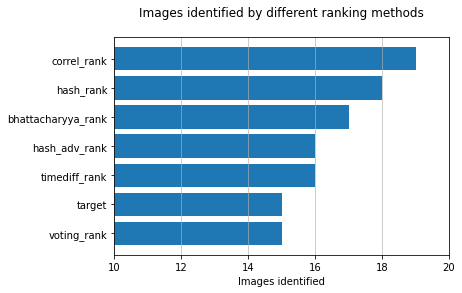

In [39]:
plt.barh(df_eval.index, df_eval['images_identified'])
plt.xlim([10, 20])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Images identified')
plt.title('Images identified by different ranking methods\n')

Text(0.5, 1.0, 'Loss of different ranking methods\n')

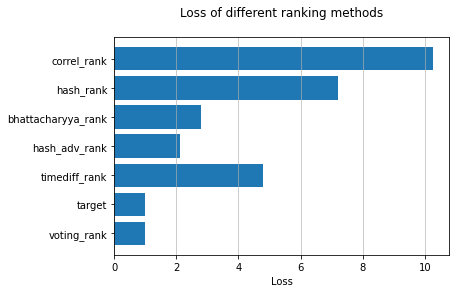

In [40]:
plt.barh(df_eval.index, df_eval['loss'])
plt.grid(which='major', axis='x', alpha=0.8)
plt.xlabel('Loss')
plt.title('Loss of different ranking methods\n')

# Identify the best images: high-pass filtering

In [41]:
df['magnitude_spectrum'] = [sc.high_pass_filtering(img) for img in gray_images]

# Alternatively:
#df['gray_images'] = gray_images
#df['Magnitude_spectrum'] = df['gray_images'].apply(lambda x: sc.high_pass_filtering(x))
#df.drop(['gray_images'], axis=1, inplace=True)

In [42]:
df.head()

,file,creation_date,timediff_value,target,timediff_rank,hash_value,hash_rank,hash_adv_value,hash_adv_rank,correl_corr,bhattacharyya_corr,correl_rank,bhattacharyya_rank,voting_diff,voting_rank,magnitude_spectrum
0,ac_0.JPG,1561815246,26.0,0,0,54,0,55,0,0.374794,0.477720,0,0,0.2,0,32767.5
1,ad_0.JPG,1561815272,12.0,1,1,38,1,44,0,0.168790,0.344085,1,1,0.0,1,33150.0
2,ae_0.JPG,1561815284,6.0,2,2,47,2,53,1,0.911994,0.616580,2,2,0.4,2,32512.5
3,ae_1.JPG,1561815290,96.0,2,3,41,3,42,2,0.264509,0.264163,2,2,0.0,2,32512.5
4,af_0.JPG,1561815386,134.0,3,4,41,4,50,3,0.874352,0.361429,3,3,0.0,3,33150.0


# Apply results

In [44]:
# TODO: outsource dataframe from function
sc.copy_imgs(df, (IMAGES, IMAGES_PROCESSED), 'timediff_value', 'magnitude_spectrum')

KeyError: 'File'

# Deep-dive: Hashing

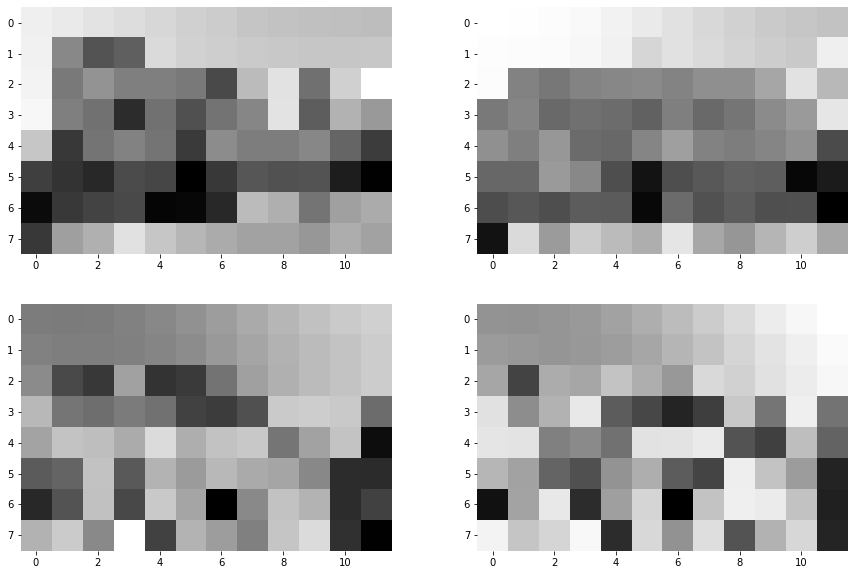

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(sc.hash_image(gray_images[0]), cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(sc.hash_image(gray_images[1]), cmap='gray')
plt.subplot(223, frame_on=False)
plt.imshow(sc.hash_image(gray_images[2]), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.hash_image(gray_images[3]), cmap='gray')

# Rotate

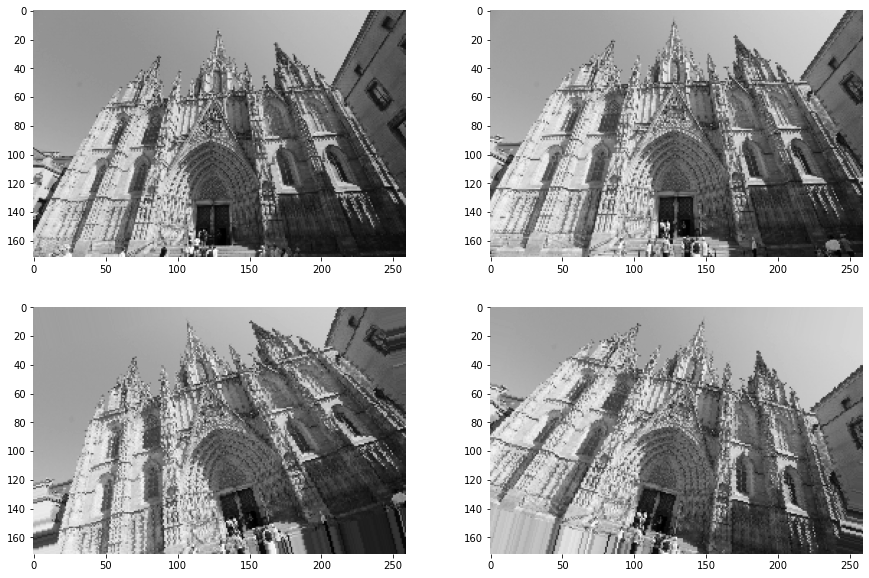

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(gray_images[7], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(gray_images[8], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.rotate_img(gray_images[8], 15), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.rotate_img(gray_images[8], -15), cmap='gray')

# Warp images

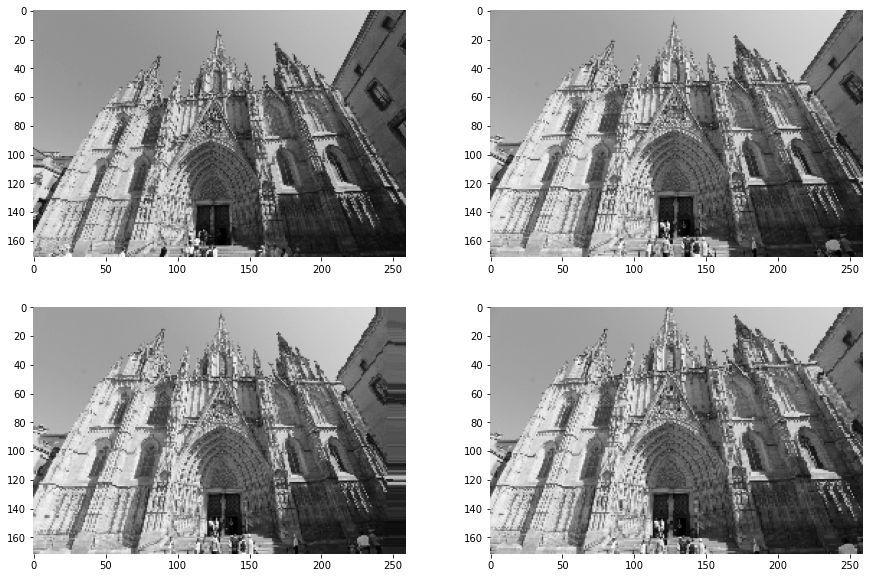

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.subplot(221, frame_on=False)
plt.imshow(gray_images[7], cmap='gray')
plt.subplot(222, frame_on=False)
plt.imshow(gray_images[8], cmap='gray')

plt.subplot(223, frame_on=False)
plt.imshow(sc.warp_img(gray_images[8], 0.05, how='left'), cmap='gray')
plt.subplot(224, frame_on=False)
plt.imshow(sc.warp_img(gray_images[8], 0.05, how='right'), cmap='gray')

# Evaluate Advanced Hashing

Text(0, 0.5, 'Number count')

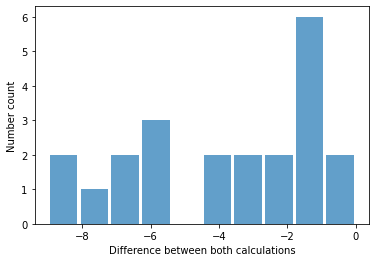

In [20]:
# TODO: evaluation missing

# two groups can be identified: small & larger differences
# small differences seem to be caused by better matching of similar images
# larger differences are rather errorneous correlations

df['hash_diff'] = df['hash_value'] - df['hash_adv_value']

plt.hist((df['hash_value'] - df['hash_adv_value']), bins=10, rwidth=0.9, alpha=0.7);
plt.xlabel('Difference between both calculations')
plt.ylabel('Number count')

# Deep dive: Correlations

In [23]:
# reasonable value

sc.calculate_loss(labels, df['bhattacharyya_rank'], n_img=n_img)

(15, 17, 2.8)

In [24]:
# not the best discriminator

sc.calculate_loss(labels, df['correl_rank'], n_img=n_img)

(15, 19, 10.266666666666666)

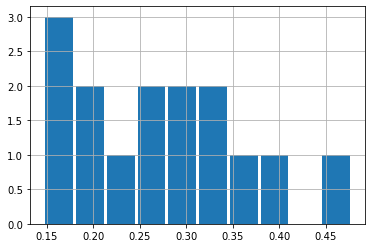

In [25]:
# a value below 0.5 is not found for non-similar images

df.groupby(['target'])['bhattacharyya_corr'].last().hist(rwidth=0.9)

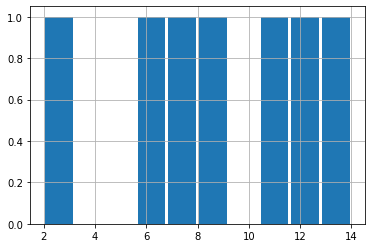

In [26]:
# similar images seem to have values higher 0.5, but this is based on low statistics only

rel_cols = (df.groupby(['target'])['bhattacharyya_corr'].agg('count') > 1).values
df.groupby(['target'])['bhattacharyya_rank'].first().iloc[rel_cols].hist(rwidth=0.9)

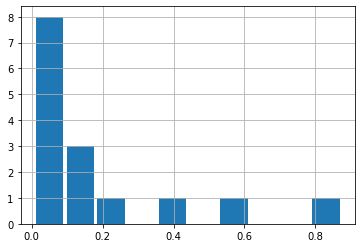

In [27]:
# repeating the same for the Correlation method 
# this function declines steeply, yet some images seem to resemble each other with values ~> 0.5

df.groupby(['target'])['correl_corr'].last().hist(rwidth=0.9)

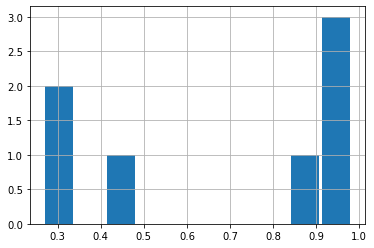

In [28]:
# similar images generally return a value close to 1

rel_cols = (df.groupby(['target'])['correl_corr'].agg('count') > 1).values
df.groupby(['target'])['correl_corr'].first().iloc[rel_cols].hist(rwidth=0.9)